# Projet d'analyse d'alimentation des citoyens de pays différents

## Partie de nettoyage des données

Dans un premier et dans le but de faciliter la compréhension des données, l'objectif est d'analyser celles-ci quantitativement et qualitativement. 

La partie suivante inclue la mise en évidence des valeurs manquantes avec au moins 3 méthodes de traitement adatpées aux variables concernées et d'identification et quantification de valeurs abbérantes.

### Imports des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

On lit le fichier `fr.openfoodfacts.org.products.csv` avec le séparateur `\t`. Les données seront dans la variable `data`

In [2]:
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")

/tmp/ipykernel_4158/1111784718.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")


### Analyse quantitative des données

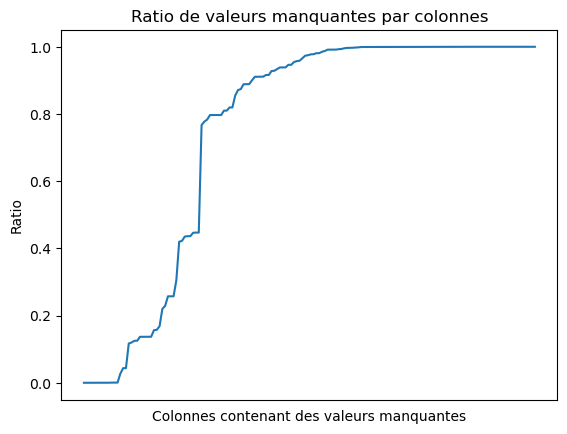

Sur tout le dataset, on a un taux de valeurs manquantes qui équivaut à 75.37 %.
Sur 162 colonnes, il y en a 17 qui n'ont aucune valeurs
Les colonnes qui n'ont aucune valeurs sont les suivantes :
['no_nutriments' 'ingredients_from_palm_oil'
 'ingredients_that_may_be_from_palm_oil' 'nutrition_grade_uk'
 'butyric-acid_100g' 'caproic-acid_100g' 'lignoceric-acid_100g'
 'cerotic-acid_100g' 'montanic-acid_100g' 'melissic-acid_100g'
 'elaidic-acid_100g' 'mead-acid_100g' 'erucic-acid_100g'
 'nervonic-acid_100g' 'chlorophyl_100g' 'glycemic-index_100g'
 'water-hardness_100g']


In [3]:
# On lis les valeurs non definies
missing = data.isna()
# On les compte et on créer un nouveau DataFrame
missing_sum = pd.DataFrame(missing.sum(), columns=['nb_manquants'])
# On calcul et ajoute le ratio du nombre de valeurs non définies au DataFrame
missing_sum["ratio"] = ((missing_sum["nb_manquants"] / len(data)) )

# On va construire un graphique pour nous montrer le nombre de valeurs manquantes
plt.title("Ratio de valeurs manquantes par colonnes")
plt.ylabel("Ratio")
plt.xlabel("Colonnes contenant des valeurs manquantes")
plt.xticks([])
plt.plot(missing_sum.sort_values(["ratio"])["ratio"])
plt.show()
# On garde les ratio == 1
missing_sum_1 = missing_sum[missing_sum["ratio"] == 1]

ratio_missing = missing_sum["nb_manquants"].sum() / data.size

print(f"Sur tout le dataset, on a un taux de valeurs manquantes qui équivaut à {(ratio_missing*100):.2f} %.")
print(f"Sur {len(missing_sum)} colonnes, il y en a {len(missing_sum_1)} qui n'ont aucune valeurs")
print(f"Les colonnes qui n'ont aucune valeurs sont les suivantes :")
print(missing_sum_1.index.to_numpy())

La conclusion de cette analyse est qu'actuellement nous disposons de 25 % de données exploitables. On aura certainement une valeur différente après le traitement des valeurs manquantes.

## conservation des données utiles au projet uniquement

In [4]:

data = data.filter([
    "url",
    "product_name",
    "generic_name",
    "quantity", 
    "packaging",
    "packaging_tags",
    "countries_tags",
    "image_url",
    "image_small_url",
    "nutrition-score-fr_100g"
    ], axis=1)

missing_ratio = pd.DataFrame(data.isna().sum(), columns=['nb_manquants']).sum() / data.size

print(f"Après conservation des données utiles au projet, il n'y a plus que {(missing_ratio[0]*100):.2f} % de valeurs manquantes.")

Après conservation des données utiles au projet, il n'y a plus que 47.50 % de valeurs manquantes.


# Traitement des erreurs sur les variables générales

### Les champs `product_name` et `generic_name`

On pourra utiliser principalement le `product_name` pour récupérer le nom du produit et en cas d'erreur essayer d'utiliser le `generic_name`.
Ainsi on peut donc d'abord corriger les données de `generic_name` pour être sûr que la valeur qui sera possiblement remplacée dans `generic_name` sera valide. Ensuite on pourra corriger les autres données de `product_name` qui n'ont pas été remplacée mais qui malgré tout ne sont pas acceptables.

Si malgré tout il y a des valeurs qui ne sont pas définies, on gardera malgré tout ces lignes car ce qui compte est d'effectuer des comparaisons avec d'autres données. De plus, si on ne conservait pas ces lignes, comme on peut le voir dans le script, il ne nous resterait peu de données à exploiter.

Les traitements à effectuer sur `generic_name` sont les suivants :
- Ne pas prendre en compte les nulls
- Il y a des champs avec uniquement un espace à l'intérieur. On ne peut corriger ces lignes
- Ne pas prendre en compte les noms trop long car sinon ce n'est plus un nom mais une description. On ne peut corriger ces lignes

Les traitements à effectuer sur `product_name` sont les suivants:
- Ne pas prendre en compte les nulls
- Remplacer les valeurs non valide par sa valeur `generic_name`, `generic_name` étant valide

In [5]:
# -------------
# generic_name

# On conserve les non null
generic_exists = data["generic_name"].notna()
# On conserve les lignes qui ne contiennent pas uniquement des espaces
generic_no_space = data["generic_name"].ne(" ")
# On conserve les noms en dessous de 50 caractères
generic_not_long = data["generic_name"].str.len() < 50
# Test booléen
generic = generic_exists & generic_no_space & generic_not_long
# Table qui contient les éléments qui respectent les critères précédents
generic_match = data.loc[generic, ["generic_name"]]
print(f"Il y a {generic_match.size} generic_names sur {data.shape[0]} qui sont considérés comme valide, soit {((generic_match.size/data.shape[0])*100):.2f} %")

# -------------
# product_name

# Retirer les nulls
product_exists = data["product_name"].notna()
# Table qui contient les éléments qui respectent les critères précédents
product_match = data.loc[product_exists, ["product_name"]]

# Colonnes qui ne contiennent pas de product_name mais contiennent un generic_name
no_product_with_generic = (~product_exists) & generic
print(f"Il y a {no_product_with_generic.value_counts()[True]} lignes pour lesquelles il existe un generic_name valide mais pas de product_name valide")

# Remplacer les product_name non valide par son generic_name valide dans data
data.loc[no_product_with_generic, ["product_name"]] = data.loc[no_product_with_generic, ["generic_name"]]

# On peut désormait retirer generic_name qui n'est plus d'aucune utilité
data.drop(["generic_name"], axis=1, inplace=True)

Il y a 21991 generic_names sur 242222 qui sont considérés comme valide, soit 9.08 %
Il y a 31 lignes pour lesquelles il existe un generic_name valide mais pas de product_name valide


### La colonne `countries_tags`

Pour le projet il est important de recenser les pays qui sont mentionnés dans nos données. Dans les données proposée, il y avais également le champ `countries` mais j'ai remarqué qu'il y avait quelques erreurs dedans. Je préfère créer un dictionnaire qui va me permettre de convertir les tags en nom pour pouvoir les utiliser plus tard.

Certains tags ne veulent rien dire, par exemple avec la valeur `Catégories complétées`. On peut donc éliminer ce type de lignes.

Il y a également un mixe entre les pays avec des valeurs en `en:...` et `fr:...`

In [6]:
import utils.countriesMap as cm
import re

countries_tags_count = data["countries_tags"].value_counts()

# On récupère toutes les valeurs possibles de tags et on en garde 1 seul exemplaire
all_countries = pd.DataFrame(countries_tags_count.index.str.split(',')).explode(0).drop_duplicates()
# Il y a des pays qui ne contiennent pas le string ":". Ce ne sont donc pas des pays
all_countries = all_countries.loc[all_countries[0].str.contains(":")]
# On retire les préfixes
all_countries[0].replace('^.*:','', regex=True, inplace=True)
# Cela peut entrainé des doublons, par exemple fr:france et en:france => france et france
all_countries.drop_duplicates(inplace=True)

def map_country(c_list):
    c_list = list(map(lambda y: re.sub('^.*:','', y),c_list))
    try :
        # On map le nom de pays dans la langue inconnue à son pays en français
        c_list = list(map(lambda y: cm.countries[y],c_list))
    except:
        return np.NaN
    return ",".join(c_list)

# Tous les pays définis
defined_countries = ~data["countries_tags"].isna()
# On créer une colonne "countries" dans laquelle on met le mapping de leur tag "countries_tags"
data.loc[defined_countries, "countries"] = data.loc[defined_countries, "countries_tags"].str.split(",").apply(map_country)

# TODO Remplacer "Tous" par tous les pays disponibles

# TODO Remplacer "gulf_countries" par les pays du Golf
# gulf-countries replace in all_countries
gulf_countries = ["Émirats Arabes Unis","Oman","Koweit","Arabie Saoudite", "Qatar"][True]

On a maintenant la colonne des pays avec le bon nom.

On peut donc retirer la colonne "countries_tags" et retirer les valeurs null restante de "countries"

In [7]:
# Maintenant que le traitement est effectué, on peut supprimer "countries_tags"
data.drop("countries_tags", axis=1, inplace=True)
# Retirer les lignes qui n'ont pas de pays
defined_countries = ~data["countries"].isna()
data = data.loc[defined_countries]

In [8]:
# On peut regarder les nombre de fois qu'un pays est dans une ligne
test = data["countries"].str.split(",").explode().value_counts()

### Le nutriscore

Notre mesure la plus importante est le nutriscore. C'est principalement grâce à elle que l'on pourra comparer les pays. 

In [10]:
missing = data["nutrition-score-fr_100g"].isna()

KeyError: 'nutriscore'